## Spatial plots of precipitation and CWV over campaign time period in 2024 and compare to climatology
- ERA-5 CWV
- GPCP 1 degree daily precipitation
- IMERG 0.1 degree 30-minute precipitation
- GSMaP 0.1 degree hourly precipitation

In [1]:
import geopy.distance
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import gridspec
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import numpy as np
import xarray as xr
import json
import cartopy
import pandas as pd
from datetime import datetime, timedelta
import cftime
#from adjustText import adjust_text
import glob
import os

# Set region to plot and start and end time

In [2]:
lonMin, lonMax = -62.1, -9.9
latMin, latMax = -2.1, 22.1
#latMin, latMax = -10.1,30.1

#start_mon = 'Aug.'
#start_day = '10'
#start_time = '08-'+start_day+'T00:00:00'
#end_mon = 'Sep.'
#end_day = '30'
#end_time = '09-'+end_day+'T00:00:00'

start_mon = 'Aug.'
start_day = '16'
start_time = '08-'+start_day+'T00:00:00'
end_mon = 'Sep.'
end_day = '24'
end_time = '09-'+end_day+'T00:00:00'

## Precipitation from GPCP

Deprecated monthly mean data

In [3]:
#precipClimoMonthlyMean = xr.open_mfdataset('/Users/awing/Dropbox/ORCESTRA/TrackPlanning_precampaign/gpcpPrecipMonthlyMean.nc')
#precip2024MonthlyMean = xr.open_mfdataset('/Users/awing/Dropbox/ORCESTRA/data/GPCP/2.5deg/GPCP_monthlymean_2024.nc')

#average august and september monthly precip
# = precipClimoMonthlyMean.mean(dim="month")
#precipClimoAS = precipClimoMonthlyMean.sel(month=slice(9,10))
#precipClimoASMean = precipClimoAS.mean(dim="month")

#precip2024ASMean = precip2024MonthlyMean.mean(dim="time")
#precip2024ASMean

Extract over campaign time period and take mean, if haven't already extracted data

In [ ]:
#Open data for the 2024 season
filepaths = glob.glob("../../data/GPCP/1deg/2024/*.nc")
gpcp2024 = xr.open_mfdataset(filepaths)

#Extract for time period of campaign and region
gpcp2024 = gpcp2024.sel(latitude=slice(latMin,latMax),longitude=slice(lonMin+360,lonMax+360),time=slice('2024-'+start_time,'2024-'+end_time))

#Save to netcdf file (uncomment if haven't run this yet)
gpcp2024.to_netcdf('../../data/GPCP/1deg/GPCP_campaign_2024.nc')

#Take mean over campaign
gpcp2024mean = gpcp2024.mean(dim='time')

Open data over campaign time period and take mean, if have already extracted data

In [8]:
#open 2024 data
gpcp2024 = xr.open_dataset('../../data/GPCP/1deg/GPCP_campaign_2024.nc')

#Take mean over campaign
gpcp2024mean = gpcp2024.mean(dim='time')

Extract data for individual years and take climatological mean

In [4]:
#Open data for all years 1996-2019
gpcp = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/gpcp/1deg/gpcp_v01r03_daily_alltime.nc')

#For each year, extract for time period of campaign and region
years = np.arange(1997,2020) #1997-2019
for yy in years:
    gpcpYear = gpcp.sel(latitude=slice(latMin,latMax),longitude=slice(lonMin+360,lonMax+360),time=slice(str(yy)+'-'+start_time, str(yy)+'-'+end_time))
    if yy == 1997:
        gpcpCampaign = gpcpYear
    else:
        gpcpCampaign = xr.concat([gpcpCampaign,gpcpYear],dim='time')

#Take climatological mean over campaign time period over all years
gpcpClimoMean = gpcpCampaign.mean(dim='time')

#Save to netcdf file (uncomment if haven't run this yet)
#gpcpClimoMean.to_netcdf('../../data/GPCP/1deg/GPCP_campaign_climo.nc')

Open climatological mean if it has already been derived

In [9]:
#open climo data
years = np.arange(1997,2020) #1997-2019
gpcpClimoMean = xr.open_dataset('../../data/GPCP/1deg/GPCP_campaign_climo.nc')

# Precipitation from IMERG

Load IMERG data that has already been combined and reorganized (by process_imerg_finalrun.py) for 2024 

In [3]:
# Load IMERG data
yy = 2024
imerg = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/imerg/imerg_finalrun_'+ str(yy) + '0809.nc')

# Convert cftime.DatetimeJulian to pandas.DatetimeIndex
imergtimes = imerg['time'].values
imergtimes_converted = pd.to_datetime([t.strftime('%Y-%m-%d %H:%M:%S') for t in imergtimes])
imerg['time'] = imergtimes_converted


In [4]:
#Extract for time period of campaign and region
imerg2024 = imerg.sel(lat=slice(latMin,latMax),lon=slice(lonMin,lonMax),time=slice(str(yy)+'-'+start_time,str(yy)+'-'+end_time))

#Take mean over campaign
imerg2024mean = imerg2024.mean(dim='time')
imerg2024mean

<xarray.Dataset> Size: 514kB
Dimensions:        (lat: 242, latv: 2, lon: 522, lonv: 2, nv: 2)
Coordinates:
  * lat            (lat) float32 968B -2.05 -1.95 -1.85 ... 21.85 21.95 22.05
  * latv           (latv) int32 8B 0 1
  * lon            (lon) float32 2kB -62.05 -61.95 -61.85 ... -10.05 -9.95
  * lonv           (lonv) int32 8B 0 1
  * nv             (nv) int32 8B 0 1
Data variables:
    lat_bnds       (lat, latv) float32 2kB -2.1 -2.0 -2.0 ... 22.0 22.0 22.1
    precipitation  (lat, lon) float32 505kB 0.07482 0.05492 ... 0.04102 0.04518
    lon_bnds       (lon, lonv) float32 4kB -62.1 -62.0 -62.0 ... -10.0 -9.9

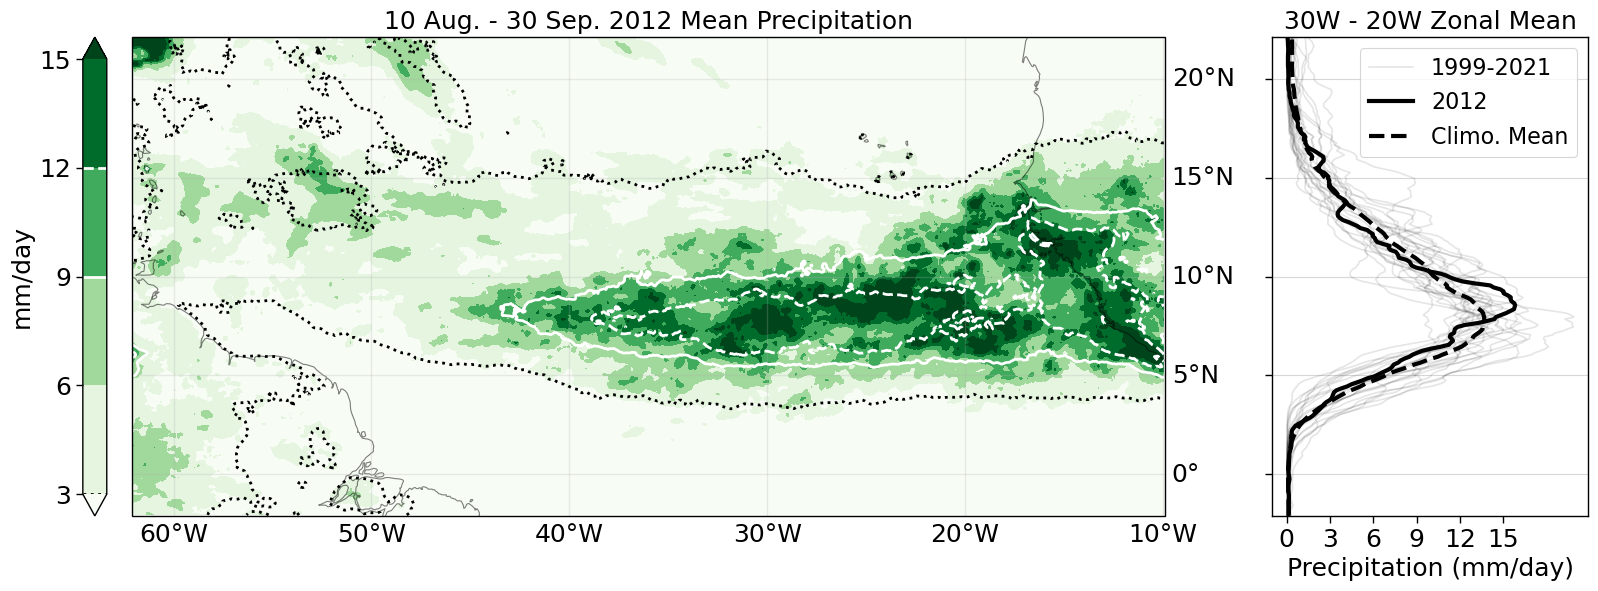

In [47]:
# plot imerg precip
fig = plt.figure(figsize = (17, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

ax1 = fig.add_subplot(gs[0],projection=ccrs.PlateCarree())
ax1.coastlines(resolution = '50m',alpha=0.5)
#ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

####################
## Plot 2024 precip as filled contours
####################
plt.contourf(imerg2024mean.lon.values,
            imerg2024mean.lat.values,
            imerg2024mean.precipitation.values*24,
            cmap = 'Greens', levels = np.linspace(3,15,5),extend = 'both')

cbar=plt.colorbar(location='left',orientation='vertical', pad=0.02)
cbar.set_label('mm/day',fontsize=18)  #add a label to the colorbar
cbar.set_ticks(np.linspace(3,15,5))
cbar.set_ticklabels([f'{x:.0f}' for x in np.linspace(3,15,5)],fontsize=18)

####################
## Plot climo precip as contours
####################
# Define contour levels, colors, and linestyles
contour_levels = [3, 9, 12]
contour_colors = ['black', 'white', 'white']
contour_styles = ['dotted', 'solid', 'dashed']

# Plot the contours on the map
for level, color, linestyle in zip(contour_levels, contour_colors, contour_styles):
    plt.contour(imergClimoMean.lon.values, imergClimoMean.lat.values, imergClimoMean.precipitation.values*24, 
                levels=[level], colors=color, linestyles=linestyle, linewidths=2)

# Manually add styled lines to the colorbar
cbar_ax = cbar.ax  # Get the colorbar axis
for level, color, linestyle in zip(contour_levels, contour_colors, contour_styles):
    cbar_ax.hlines(y=level, xmin=0, xmax=1.5, colors=color, linestyles=linestyle, linewidth=2)


#################
# Set the plot limits and title
#################
ax1.set_title(start_day+' '+start_mon+' - '+end_day+' '+end_mon + ' ' + str(yy) + ' Mean Precipitation',size=18)
ax1.set_xlim(lonMin, lonMax)
ax1.set_ylim(latMin, latMax)

################
# Plot zonal mean precip
################
ax2 = fig.add_subplot(gs[1])

lon1 = -30
lon2 = -20

zonalmean_precip_climo = imergClimoMean.precipitation.sel(lon=slice(lon1,lon2)).mean(dim='lon')
zonalmean_precip_2024 = imerg2024mean.precipitation.sel(lon=slice(lon1,lon2)).mean(dim='lon')

for i in range(len(years_imerg)):
    if i == 0:
        ax2.plot(imerg_zonalmean_precip.precipitation[i].values*24,imerg_zonalmean_precip.lat,label=str(years_imerg[0]) + '-' + str(years_imerg[-1]),color='k',alpha=0.1,linestyle='-')
    else:
        ax2.plot(imerg_zonalmean_precip.precipitation[i].values*24,imerg_zonalmean_precip.lat,color='k',alpha=0.1,linestyle='-')

ax2.plot(zonalmean_precip_2024.values*24,zonalmean_precip_2024.lat,label=str(yy),color='k',linewidth=3)
ax2.plot(zonalmean_precip_climo.values*24,zonalmean_precip_climo.lat,label='Climo. Mean',color='k',linestyle='--',linewidth=3)

ax2.set_xticks([0,3,6,9,12,15])
plt.setp(ax2.get_xticklabels(), fontsize=18)
#plt.setp(ax2.get_yticklabels(), fontsize=18)
ax2.set_yticks([0,5,10,15,20])
ax2.set_yticklabels([])
ax2.grid(True,which='major',axis='y',alpha=0.5)
ax2.legend(fontsize=16)
ax2.set_ylim([latMin,latMax])
#ax2.set_ylabel('Latitude',size=18)
ax2.set_xlabel('Precipitation (mm/day)',size=18)
ax2.set_title(str(-1*lon1) + "W - " + str(-1*lon2) + "W Zonal Mean",size=18)

sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.
#plt.show()

# Save figure
plt.savefig('../../figures/Fig_precip_zonalmean_'+str(yy)+'_wclimo_IMERG.png')

Climatological mean data and zonal mean data for individual years that has already been processed (by process_imerg_finalrun_climo.py)

In [6]:
#open climo data
years_imerg = np.arange(1999,2022) #1999-2021
imergClimoMean = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/imerg/imerg_campaign_climo.nc')

In [7]:
#open zonal mean data
imerg_zonalmean_precip = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/imerg/imerg_zonalmean_precip.nc')
imerg_zonalmean_precip

<xarray.Dataset> Size: 68kB
Dimensions:        (time: 23, lat: 242, latv: 2, lonv: 2, nv: 2)
Coordinates:
  * lat            (lat) float32 968B -2.05 -1.95 -1.85 ... 21.85 21.95 22.05
  * latv           (latv) int32 8B 0 1
  * lonv           (lonv) int32 8B 0 1
  * nv             (nv) int32 8B 0 1
  * time           (time) int64 184B 1999 2000 2001 2002 ... 2018 2019 2020 2021
Data variables:
    lat_bnds       (time, lat, latv) float32 45kB ...
    precipitation  (time, lat) float32 22kB ...
    lon_bnds       (time, lonv) float32 184B ...

# Precip from GSMap

In [10]:
gsmap = xr.open_dataset('ipfs://QmU9ShLg6NgWG2VxYddgWjynUYZtZvfw1EBFHtPAwmWjYK',engine='zarr')
#already restricted to region and campaign time period
gsmap

<xarray.Dataset> Size: 5GB
Dimensions:              (time: 1151, lat: 240, lon: 520)
Coordinates:
  * lat                  (lat) float32 960B -1.95 -1.85 -1.75 ... 21.85 21.95
  * lon                  (lon) float32 2kB -61.95 -61.85 ... -10.15 -10.05
  * time                 (time) datetime64[ns] 9kB 2024-08-10 ... 2024-09-30T...
Data variables:
    gaugeQualityInfo     (time, lat, lon) float32 575MB ...
    hourlyPrecipRate     (time, lat, lon) float32 575MB ...
    hourlyPrecipRateGC   (time, lat, lon) float32 575MB ...
    observationTimeFlag  (time, lat, lon) float32 575MB ...
    orographicRainFlag   (time, lat, lon) int32 575MB ...
    reliabilityFlag      (time, lat, lon) int8 144MB ...
    satelliteInfoFlag    (time, lat, lon) float64 1GB ...
    snowProbability      (time, lat, lon) float32 575MB ...
    surfaceType          (time, lat, lon) int16 287MB ...
Attributes: (12/14)
    Conventions:                CF-1.6
    FileHeader:                 DOI=;\nDOIauthority=http://dx.doi.org/;\nDOIs...
    FileInfo:                   DataFormatVersion=6a;\nTKCodeBuildVersion=0;\...
    GSMaPInfo:                  AlgorithmName=GSMaP_MVK-Gauge_hourly;\nCovera...
    GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration=CENT...
    JAXAInfo:                   GranuleFirstScanUTCDateTime=;\nGranuleLastSca...
    ...                         ...
    creator_name:               Bjorn Stevens
    history:                    Wed Aug 14 05:47:03 2024: ncks -A -m /app/wor...
    history_of_appended_files:  Wed Aug 14 05:47:03 2024: Appended file /app/...
    license:                    CC-BY-4.0
    summary:                    GSMaP slices of hourly 0.1deg precipitation d...
    title:                      Subset of GSMaP (v4) MVK-Gauge hourly data

In [11]:
#Take mean over campaign
gsmap2024mean = gsmap.mean(dim='time')

# ERA-5 data

In [10]:
era5 = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/era5/ERA5_hrly_OLR_Prec_PW_20240809.nc')

In [15]:
# average ERA-5 CWV and precip over time period of cruise/campaign
start_time_dt = np.datetime64('2024-'+start_time)
index_start = np.where(pd.to_datetime(era5.valid_time) == start_time_dt)[0]
index_start = int(index_start[0])

end_time_dt = np.datetime64('2024-'+end_time)
index_end = np.where(pd.to_datetime(era5.valid_time) == end_time_dt)[0]
index_end = int(index_end[0])

tcwv_mean = era5.tcwv[index_start:index_end].mean(dim='valid_time')
tcwv_bowtie = tcwv_mean.sel(latitude=slice(latMax,latMin), longitude=slice(lonMin,lonMax))
np.max(tcwv_bowtie)
#np.min(tcwv_bowtie)

era5precip2024mean = era5.mtpr[index_start:index_end].mean(dim='valid_time')*3600*24 #convert to mm/day

In [14]:
era5precip2024mean

<xarray.DataArray 'mtpr' (latitude: 241, longitude: 601)> Size: 579kB
array([[1.3429136 , 1.173987  , 1.1333437 , ..., 0.7396922 , 0.5891015 ,
        0.43260348],
       [1.3101717 , 1.1504594 , 1.1106322 , ..., 0.62413216, 0.5939399 ,
        0.4558956 ],
       [1.1982638 , 1.1523023 , 1.112635  , ..., 0.46517706, 0.43459785,
        0.45902586],
       ...,
       [0.467407  , 0.5173823 , 0.50674605, ..., 2.1302588 , 2.1689582 ,
        2.246635  ],
       [0.4890582 , 0.5370392 , 0.50348955, ..., 1.9974148 , 2.0247376 ,
        2.0651958 ],
       [0.56111395, 0.43983176, 0.5472969 , ..., 1.9217408 , 1.8393433 ,
        1.8162951 ]], shape=(241, 601), dtype=float32)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 2kB 50.0 49.75 49.5 49.25 ... -9.5 -9.75 -10.0
  * longitude  (longitude) float64 5kB -90.0 -89.75 -89.5 ... 59.5 59.75 60.0

# Coordinates

In [5]:
coordinates = {'mindeloNorth': 16.88, 'mindeloEast': -24.98, 'bcoNorth': 13.15, 'bcoEast': -59.42} 
latitudePirata = [-10,0,15,0,8,0,12,4,0,-6,0,-8,-14,-19,11.5,4,-6,21,20]
longitudePirata = [-10,-10,-38,-35,-38,0,-38,-38,-23,-10,-23,-30,-32,-34,-23,-23,8,-23,-38]

## Ship location as a function of time

In [6]:
DSHIP = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/M203/Dship_data/data/meteor_meteo_dship_20240923.nc')

In [7]:
#Ship track info
shipLat = DSHIP.lat
shipLon = DSHIP.lon
shipTrackTime = DSHIP.time
shipHeading = DSHIP.ship_heading
#shipHeading = calcshipHeading(shipLon,shipLat)
DSHIP.close()

In [10]:
#average longitude and latitude of ship
ship_start = np.datetime64('2024-08-16T08:30:00')
ship_end = np.datetime64('2024-09-23T22:59:00')
i_ship_start = np.where(pd.to_datetime(shipTrackTime) == ship_start)[0]
i_ship_start = int(i_ship_start[0])
i_ship_end = np.where(pd.to_datetime(shipTrackTime) == ship_end)[0]
i_ship_end = int(i_ship_end[0])

shipLatMean = shipLat[i_ship_start:i_ship_end].mean()
shipLonMean = shipLon[i_ship_start:i_ship_end].mean()

print('shipLatMean: ',shipLatMean)
print('shipLonMean: ',shipLonMean)

shipLatMean:  <xarray.DataArray 'lat' ()> Size: 8B
array(9.98754089)
shipLonMean:  <xarray.DataArray 'lon' ()> Size: 8B
array(-34.8246005)


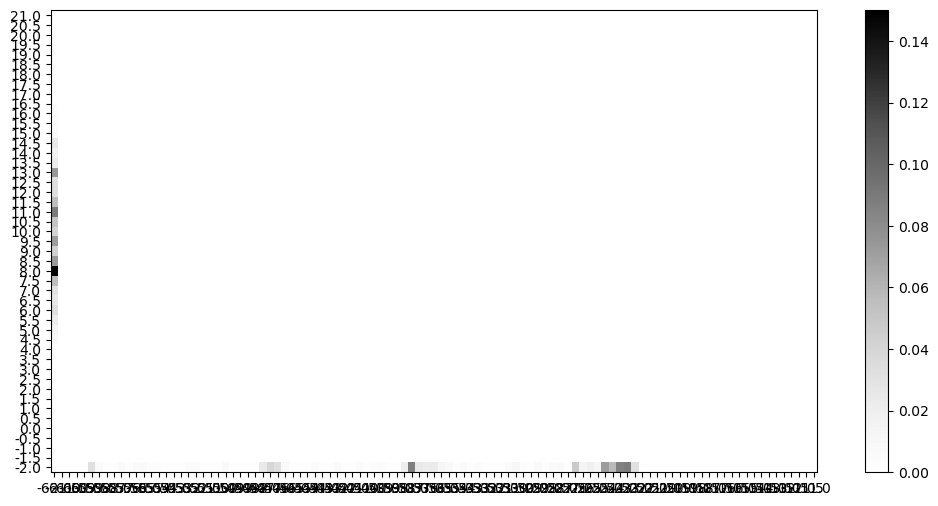

In [32]:
#Fraction of time spent at each latitude and longitude
#latbins = np.arange(4,19.5,0.5)
#lonbins = np.arange(-60,-20.5,0.5)  
latbins = np.arange(-2,22,0.5)
lonbins = np.arange(-62,-10,0.5)

latHist, latEdges = np.histogram(shipLat[i_ship_start:i_ship_end],bins=latbins)
lonHist, lonEdges = np.histogram(shipLon[i_ship_start:i_ship_end],bins=lonbins)

latFreq = latHist/len(shipLat[i_ship_start:i_ship_end])
lonFreq = lonHist/len(shipLon[i_ship_start:i_ship_end])

#Plotting
fig = plt.figure(figsize = (17, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])
ax1 = fig.add_subplot(gs[0])

#ax1 = fig.add_subplot(gs[0],projection=ccrs.PlateCarree())
#ax1.coastlines(resolution = '50m',alpha=0.5)
#gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
#gl.top_labels = False
#gl.right_labels = False
#gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20])
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'size': 18}
#gl.ylabel_style = {'size': 18}

#plt.plot(latbins[:-1],latFreq)
plt.pcolormesh(latFreq.reshape(-1,1),vmin=0,vmax=0.15,cmap='Grays')
plt.yticks(ticks=np.arange(len(latbins)-1)+0.5, labels=latbins[:-1], rotation=0)
#ax1.set_ylim(latMin,latMax)
#ax1.set_yticklabels([])

plt.pcolormesh(lonFreq.reshape(-1,1).transpose(),vmin=0,vmax=0.15,cmap='Grays')
plt.xticks(ticks=np.arange(len(lonbins)-1)+0.5, labels=lonbins[:-1], rotation=0)
#ax1.set_xlim(lonMin,lonMax)
plt.colorbar()
plt.show()


In [52]:
#planned track

planLON = [-24.98, -23, -23, -23.4, -23.4, -23.8, -32, -32, -32.4, -32.4, -32.8, -47, -47, -47.4, -47.4, -47.4, -59.42]
planLAT = [16.88, 14.5, -0.5, 14.5, 2.5, 7.5, 7.5, 14.5, 2.5, 14.5, 7.5, 7.5, 14.5, 5, 7.9, 14.9, 13.15]

Plot the ship track compared to planned track

/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_53816/2767214444.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


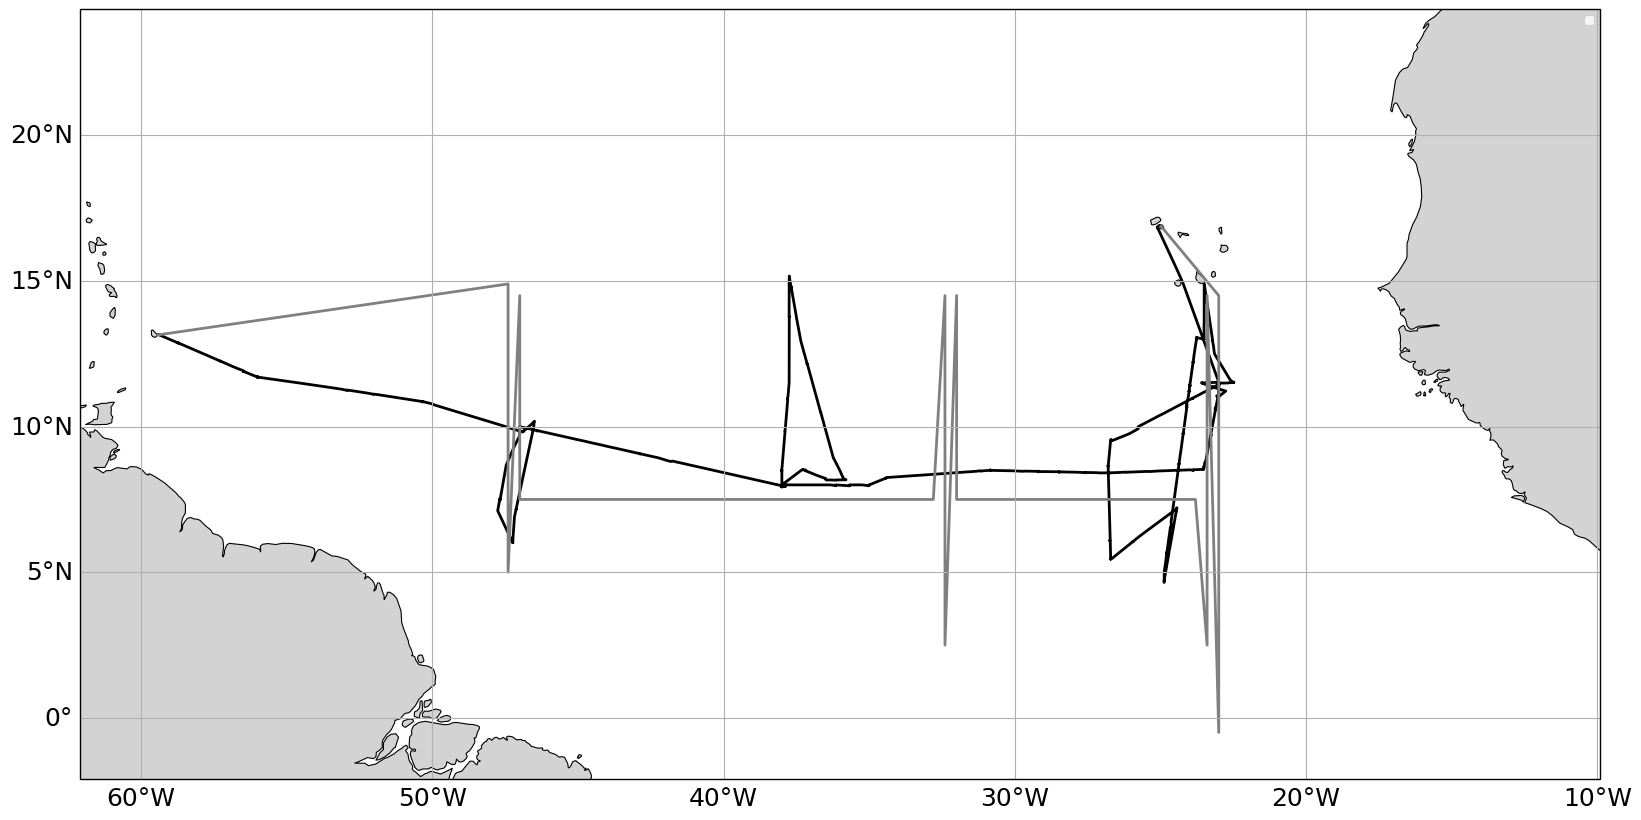

In [59]:
# create figure
fig = plt.figure(figsize=(20,10))
proj = cartopy.crs.PlateCarree()#central_longitude=offset)
ax = fig.add_subplot(111,projection=proj)

plt.plot(shipLon, shipLat, linewidth=2,color='k')
plt.plot(planLON, planLAT, linewidth=2,color='gray')

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
# ax.add_feature(cartopy.feature.STATES)
gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
    xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5))
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

# select plotting area
plt_area=[lonMin, lonMax, latMin, latMax] # W,E,S,N
ax.set_extent(plt_area)

plt.legend(loc="upper right")

plt.show()
plt.close()

# Precip statistics from GPCP

In [11]:
# peak precip
#precipClimoASMean_box = precipClimoASMean.sel(latitude=slice(latMin,latMax),longitude=slice(lonMin+360,lonMax+360))
#precipClimo_peak = np.max(precipClimoASMean_box.precip.values)
precipClimoMean_box = gpcpClimoMean.sel(latitude=slice(0,20),longitude=slice(-60+360,-20+360))
precipClimo_peak = np.max(precipClimoMean_box.precip.values)

#iprecipClimo_peak = np.squeeze(np.where(precipClimoASMean_box.precip.values == precipClimo_peak))
iprecipClimo_peak = np.squeeze(np.where(precipClimoMean_box.precip.values == precipClimo_peak))

#print("climo peak precip is",precipClimo_peak,"at latitude",precipClimoASMean_box.latitude[iprecipClimo_peak[0]].values,"and longitude",precipClimoASMean_box.longitude[iprecipClimo_peak[1]].values-360)
print("climo peak precip is",precipClimo_peak,"at latitude",precipClimoMean_box.latitude[iprecipClimo_peak[0]].values,"and longitude",precipClimoMean_box.longitude[iprecipClimo_peak[1]].values-360)

#precip2024ASMean_box = precip2024ASMean.sel(lat=slice(latMin,latMax),lon=slice(lonMin+360,lonMax+360))
#precip2024_peak = np.max(precip2024ASMean_box.precip.values)
precip2024mean_box = gpcp2024mean.sel(latitude=slice(0,20),longitude=slice(-60+360,-20+360))
precip2024_peak = np.max(precip2024mean_box.precip.values)

#iprecip2024_peak = np.squeeze(np.where(precip2024ASMean_box.precip.values == precip2024_peak))
iprecip2024_peak = np.squeeze(np.where(precip2024mean_box.precip.values == precip2024_peak))

#print("2024 peak precip is",precip2024_peak,"at latitude",precip2024ASMean_box.lat[iprecip2024_peak[0]].values,"and longitude",precip2024ASMean_box.lon[iprecip2024_peak[1]].values-360)
print("2024 peak precip is",precip2024_peak,"at latitude",precip2024mean_box.latitude[iprecip2024_peak[0]].values,"and longitude",precip2024mean_box.longitude[iprecip2024_peak[1]].values-360)

climo peak precip is 12.409225 at latitude 8.0 and longitude -32.0
2024 peak precip is 15.692888 at latitude 8.0 and longitude -29.0


Precip or CWV over region

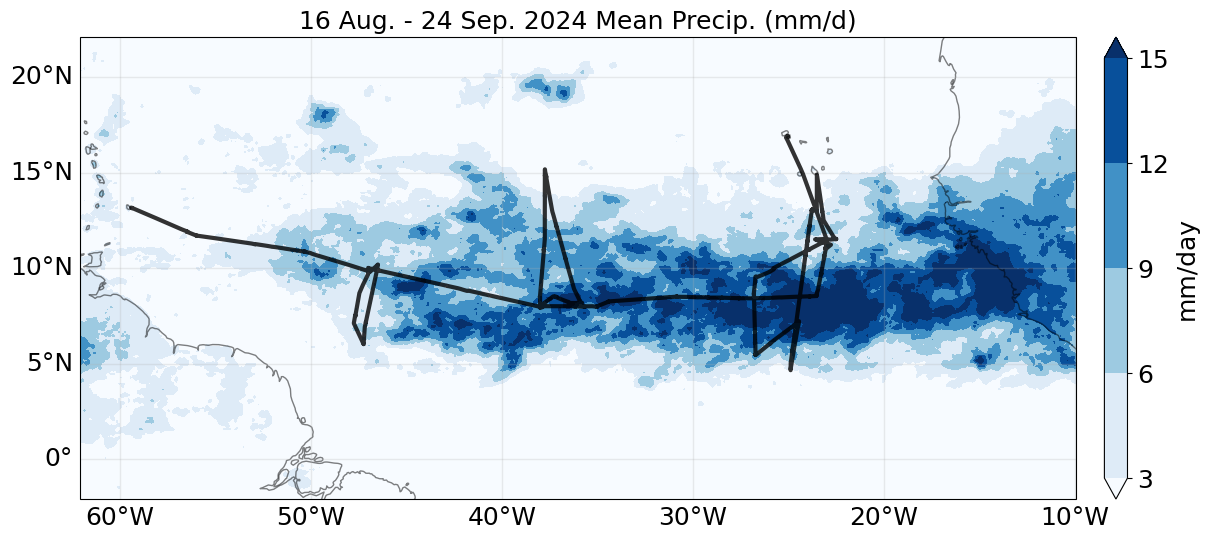

In [25]:
plt.figure(figsize = (18, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution = '50m',alpha=0.5)
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

####################
## Plot climo precip as shading
####################
#plt.pcolormesh(gpcpClimoMean.longitude.values-360.0, 
#               gpcpClimoMean.latitude.values,
#               gpcpClimoMean.precip.values,
#               vmin = 0.0, vmax = 15, cmap = 'Blues', alpha = 0.75,
#               shading='nearest')

####################
## Plot 2024 precip as shading
####################
#plt.pcolormesh(gpcp2024mean.longitude.values, 
#               gpcp2024mean.latitude.values,
#               gpcp2024mean.precip.values,
#               cmap = 'Greens', levels = np.linspace(3,15,5),extend = 'both')
#               vmin = 0.0, vmax = 13, cmap = 'Blues', alpha = 0.75,
#               shading='nearest')

#Colorbar for shaded precip
#cbar=plt.colorbar()
#cbar.ax.tick_params(labelsize=18)

plt.contourf(imerg2024mean.lon.values,
            imerg2024mean.lat.values,
            imerg2024mean.precipitation.values*24,
            cmap = 'Blues', levels = np.linspace(3,15,5),extend = 'both')

cbar=plt.colorbar(location='right',orientation='vertical', pad=0.02)
cbar.set_label('mm/day',fontsize=18)  #add a label to the colorbar
cbar.set_ticks(np.linspace(3,15,5))
cbar.set_ticklabels([f'{x:.0f}' for x in np.linspace(3,15,5)],fontsize=18)

#####################
## Plot 2024 precip as contours
#####################
#CS = plt.contour(gpcp2024mean.longitude.values-360.0, 
#               gpcp2024mean.latitude.values,
#               gpcp2024mean.precip.values,levels=np.linspace(0,15,6))
#ax.clabel(CS, inline=True, fontsize=10)

###################
## Plot 2024 column water vapor as contours
###################
#plt.contour(era5.longitude.values,era5.latitude.values,tcwv_mean,levels = np.linspace(33,58,26),linewidth = 1)

#################
## Plot 2024 column water vapor as filled contours
#################
#plt.contourf(era5.longitude.values, 
#            era5.latitude.values,
#            tcwv_mean,
#            cmap = 'Blues', levels = np.linspace(33,58,26),extend = 'both')

# colorbar for cwv as filled contours
#cbar=plt.colorbar(orientation='vertical', pad=0.02)
#cbar.set_label('CWV (mm)',fontsize=18)  #add a label to the colorbar
#cbar.set_ticks(np.linspace(33,58,6))
#cbar.set_ticklabels([f'{x:.0f}' for x in np.linspace(33,58,6)],fontsize=18)

#################
## Plot 48 mm contour
#################
#plt.contour(era5.longitude.values,era5.latitude.values, tcwv_mean,levels = [48],colors = 'r',linewidth = 2)

#################
# Set the plot limits and title
#################
#plt.title(start_day+' '+start_mon+' - '+end_day+' '+end_mon+' 2024 and Climo. Mean Precip. (mm/day)',size=18)
plt.title(start_day+' '+start_mon+' - '+end_day+' '+end_mon+' 2024 Mean Precip. (mm/d)',size=18)
#plt.title(start_day+' '+start_mon+' - '+end_day+' '+end_mon+' 2024 Mean Column-Integrated Water Vapor',size=18)

#cbar.ax.tick_params(labelsize=18)
ax.set_xlim(lonMin, lonMax)
ax.set_ylim(latMin, latMax)

################
## Plot ship track
################
p1 = plt.plot(shipLon,shipLat, alpha=0.8, color = 'k',linewidth= 3)
#p2 = plt.plot(planLON,planLAT, alpha=0.2, color = 'k',linewidth= 2)

#plot PIRATA array
#plt.scatter(longitudePirata[0:4], latitudePirata[0:4], color = 'r', label = 'PIRATA', alpha = 0.25)
#plt.plot(longitudePirata[4], latitudePirata[4], color = 'r', label = 'PIRATA', alpha = 1.0,marker='o',markersize=6)
#plt.scatter(longitudePirata[5:14], latitudePirata[5:14], color = 'r', label = 'PIRATA', alpha = 0.25)
#plt.plot(longitudePirata[14], latitudePirata[14], color = 'r', label = 'PIRATA', alpha = 1.0,marker='o',markersize=6)
#plt.scatter(longitudePirata[14:20], latitudePirata[14:20], color = 'r', label = 'PIRATA', alpha = 0.25)
#plt.plot(-47, 10, color = 'm', alpha = 1.0,marker='o',markersize=6)
##plt.plot(coordinates['bcoEast'], coordinates['bcoNorth'], marker = 'X',markersize=10)

################
## Save figure
################
plt.savefig('../../figures/Fig_precip_2024_wtrack_IMERG.png',bbox_inches='tight', dpi=300)

Zonal mean precip

Text(0.5, 1.0, '10 Aug. - 30 Sep. Zonal Mean Precip. [35W - 25W]')

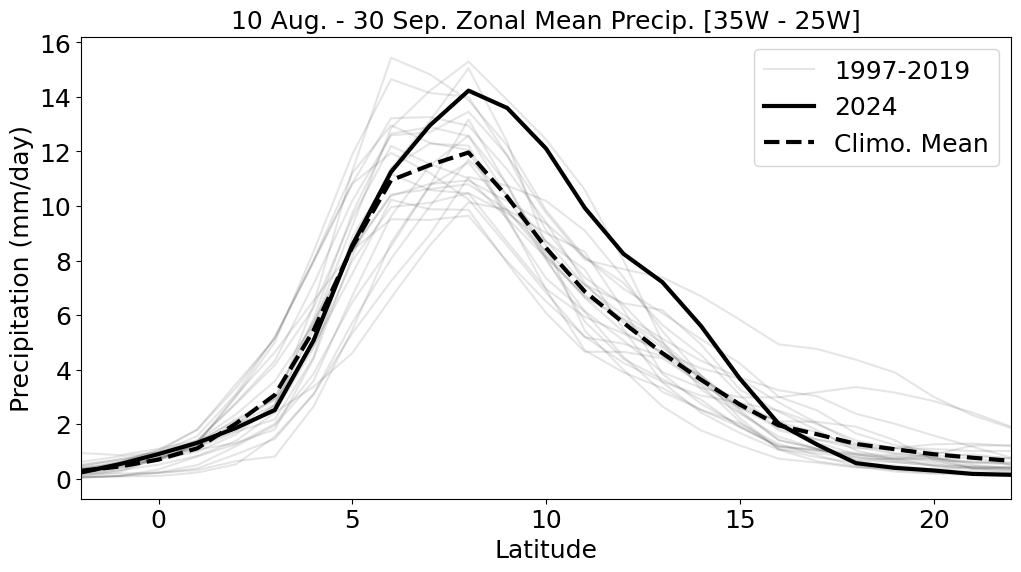

In [36]:
#Plot zonal mean precip climo and 2024 precip contours
plt.figure(figsize=(12,6))

lon1 = -35
lon2 = -25

zonalmean_precip_climo = gpcpClimoMean.precip.sel(longitude=slice(lon1+360,lon2+360)).mean(dim='longitude')
zonalmean_precip_2024 = gpcp2024mean.precip.sel(longitude=slice(lon1+360,lon2+360)).mean(dim='longitude')

#plot zonal mean precip for each year
for yy in years:
    precip_year = gpcpCampaign.precip.sel(longitude=slice(lon1+360,lon2+360),time=slice(str(yy)+'-08-10T00:00:00', str(yy)+'-09-30T00:00:00')).mean(dim='time')
    zonalmean_precip_year = precip_year.mean(dim='longitude')
    if yy == 2019:
        plt.plot(zonalmean_precip_year.latitude,zonalmean_precip_year.values,label='1997-2019',color='k',alpha=0.1,linestyle='-')
    else:
        plt.plot(zonalmean_precip_year.latitude,zonalmean_precip_year.values,color='k',alpha=0.1,linestyle='-')


plt.plot(zonalmean_precip_2024.latitude,zonalmean_precip_2024.values,label='2024',color='k',linewidth=3)
plt.plot(zonalmean_precip_climo.latitude,zonalmean_precip_climo.values,label='Climo. Mean',color='k',linestyle='--',linewidth=3)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.xlim([-2,22])
plt.xlabel('Latitude',size=18)
plt.ylabel('Precipitation (mm/day)',size=18)
plt.title("10 Aug. - 30 Sep. Zonal Mean Precip. [35W - 25W]",size=18)

#plt.savefig('../../figures/Fig_zonalmean_precip 2024_wclimo_1deg.png')


# Plot precip distribution and zonal mean together on same plot

GPCP

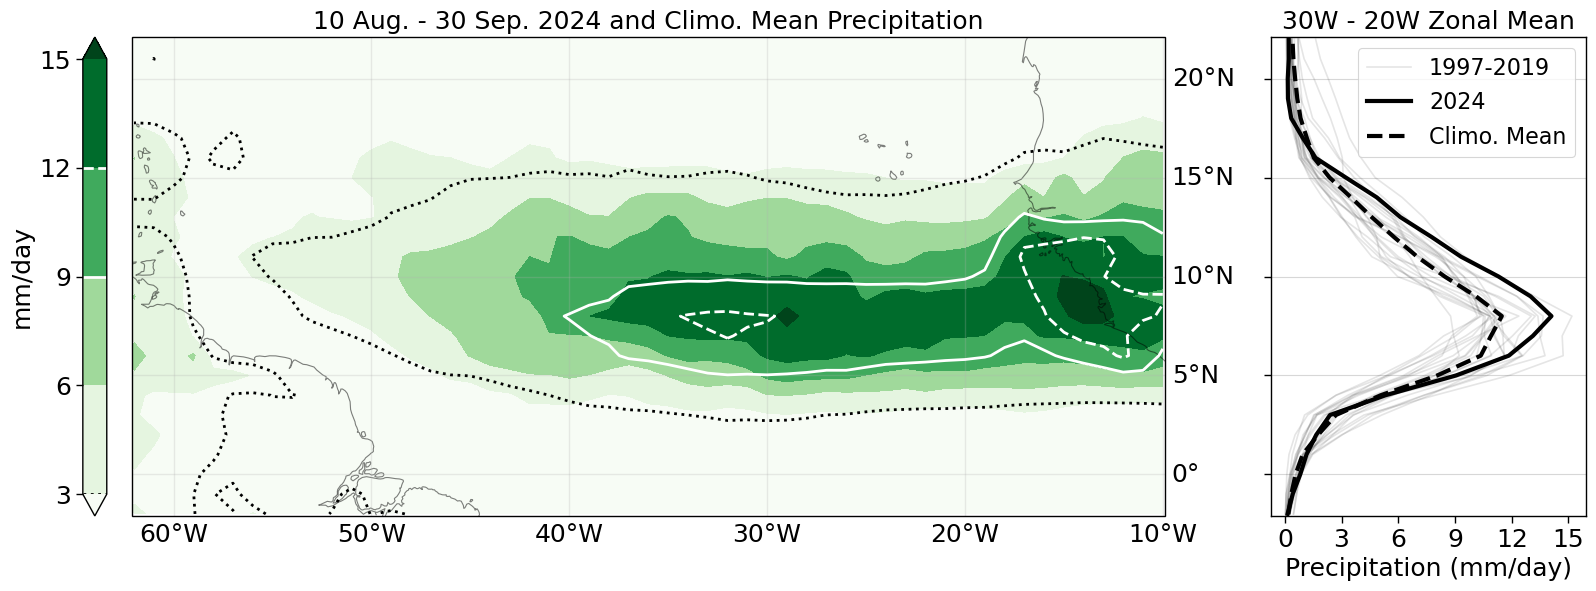

In [23]:
fig = plt.figure(figsize = (17, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

ax1 = fig.add_subplot(gs[0],projection=ccrs.PlateCarree())
ax1.coastlines(resolution = '50m',alpha=0.5)
#ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

####################
## Plot 2024 precip as filled contours
####################
plt.contourf(gpcp2024mean.longitude.values-360,
            gpcp2024mean.latitude.values,
            gpcp2024mean.precip.values,
            cmap = 'Greens', levels = np.linspace(3,15,5),extend = 'both')

cbar=plt.colorbar(location='left',orientation='vertical', pad=0.02)
cbar.set_label('mm/day',fontsize=18)  #add a label to the colorbar
cbar.set_ticks(np.linspace(3,15,5))
cbar.set_ticklabels([f'{x:.0f}' for x in np.linspace(3,15,5)],fontsize=18)

####################
## Plot climo precip as contours
####################
# Define contour levels, colors, and linestyles
contour_levels = [3, 9, 12]
contour_colors = ['black', 'white', 'white']
contour_styles = ['dotted', 'solid', 'dashed']

# Plot the contours on the map
for level, color, linestyle in zip(contour_levels, contour_colors, contour_styles):
    plt.contour(gpcpClimoMean.longitude.values, gpcpClimoMean.latitude.values, gpcpClimoMean.precip.values, 
                levels=[level], colors=color, linestyles=linestyle, linewidths=2)

# Manually add styled lines to the colorbar
cbar_ax = cbar.ax  # Get the colorbar axis
for level, color, linestyle in zip(contour_levels, contour_colors, contour_styles):
    cbar_ax.hlines(y=level, xmin=0, xmax=1.5, colors=color, linestyles=linestyle, linewidth=2)

#################
# Set the plot limits and title
#################
ax1.set_title(start_day+' '+start_mon+' - '+end_day+' '+end_mon+' 2024 and Climo. Mean Precipitation',size=18)
ax1.set_xlim(lonMin, lonMax)
ax1.set_ylim(latMin, latMax)

################
## Plot points indicating average lat/lon of ship
################
#plt.plot(lonMax-0.25,shipLatMean,marker=0,color='r',markersize=10)
#plt.plot(shipLonMean,latMin+0.25,marker=2,color='r',markersize=10)

################
# Plot zonal mean precip
################
ax2 = fig.add_subplot(gs[1])

lon1 = -30
lon2 = -20

zonalmean_precip_climo = gpcpClimoMean.precip.sel(longitude=slice(lon1+360,lon2+360)).mean(dim='longitude')
zonalmean_precip_2024 = gpcp2024mean.precip.sel(longitude=slice(lon1+360,lon2+360)).mean(dim='longitude')

#plot zonal mean precip for each year
for yy in years:
    precip_year = gpcpCampaign.precip.sel(longitude=slice(lon1+360,lon2+360),time=slice(str(yy)+'-08-10T00:00:00', str(yy)+'-09-30T00:00:00')).mean(dim='time')
    zonalmean_precip_year = precip_year.mean(dim='longitude')
    if yy == 2019:
        ax2.plot(zonalmean_precip_year.values,zonalmean_precip_year.latitude,label=str(years[0]) + '-' + str(years[-1]),color='k',alpha=0.1,linestyle='-')
    else:
        ax2.plot(zonalmean_precip_year.values,zonalmean_precip_year.latitude,color='k',alpha=0.1,linestyle='-')


ax2.plot(zonalmean_precip_2024.values,zonalmean_precip_2024.latitude,label='2024',color='k',linewidth=3)
ax2.plot(zonalmean_precip_climo.values,zonalmean_precip_climo.latitude,label='Climo. Mean',color='k',linestyle='--',linewidth=3)

ax2.set_xticks([0,3,6,9,12,15])
plt.setp(ax2.get_xticklabels(), fontsize=18)
#plt.setp(ax2.get_yticklabels(), fontsize=18)
ax2.set_yticks([0,5,10,15,20])
ax2.set_yticklabels([])
ax2.grid(True,which='major',axis='y',alpha=0.5)
ax2.legend(fontsize=16)
ax2.set_ylim([latMin,latMax])
#ax2.set_ylabel('Latitude',size=18)
ax2.set_xlabel('Precipitation (mm/day)',size=18)
ax2.set_title(str(-1*lon1) + "W - " + str(-1*lon2) + "W Zonal Mean",size=18)

sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

# Save figure
#plt.savefig('../../figures/Fig_precip_zonalmean_2024_wclimo_1deg.png')

In [98]:
colors_CC

[array([0.77524029, 0.85830065, 0.9368243 , 1.        ]),
 array([0.12710496, 0.44018454, 0.70749712, 1.        ])]

IMERG

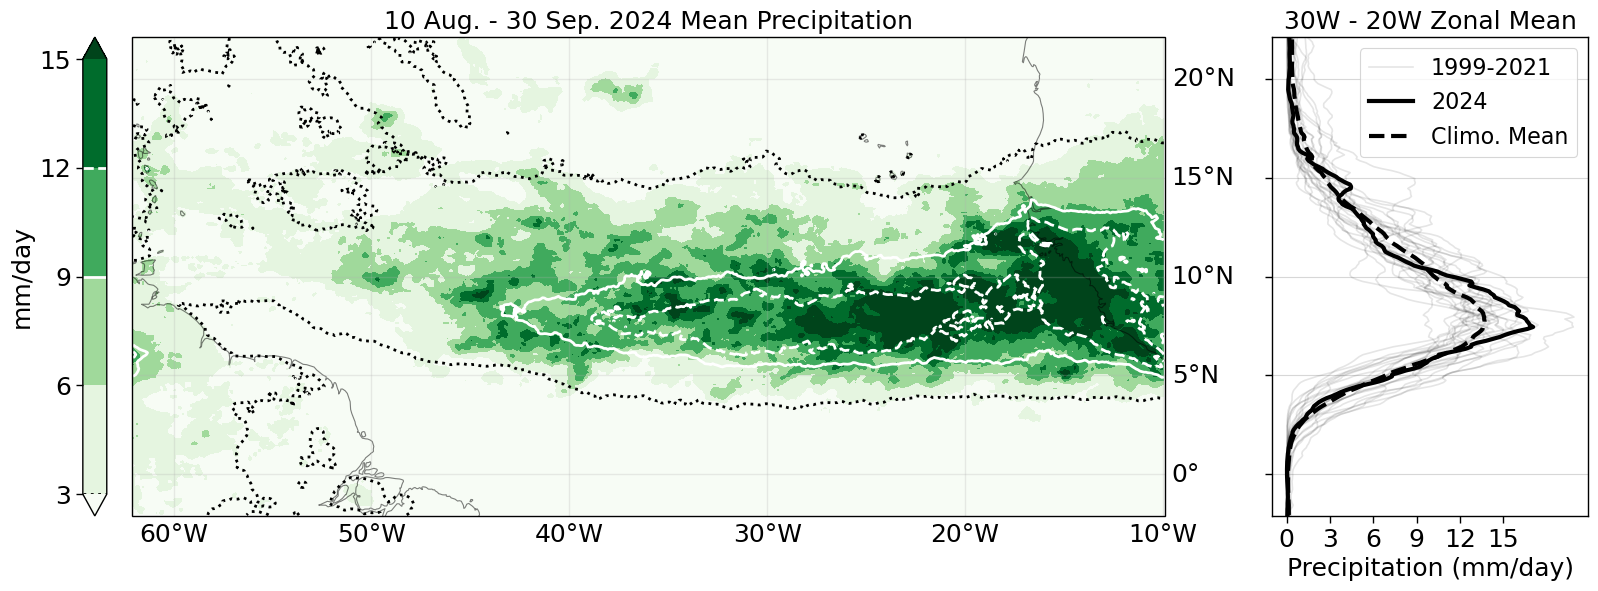

In [53]:
# plot imerg precip
fig = plt.figure(figsize = (17, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

ax1 = fig.add_subplot(gs[0],projection=ccrs.PlateCarree())
ax1.coastlines(resolution = '50m',alpha=0.5)
#ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

####################
## Plot 2024 precip as filled contours
####################
plt.contourf(imerg2024mean.lon.values,
            imerg2024mean.lat.values,
            imerg2024mean.precipitation.values*24,
            cmap = 'Greens', levels = np.linspace(3,15,5),extend = 'both')

cbar=plt.colorbar(location='left',orientation='vertical', pad=0.02)
cbar.set_label('mm/day',fontsize=18)  #add a label to the colorbar
cbar.set_ticks(np.linspace(3,15,5))
cbar.set_ticklabels([f'{x:.0f}' for x in np.linspace(3,15,5)],fontsize=18)

####################
## Plot climo precip as contours
####################
# Define contour levels, colors, and linestyles
contour_levels = [3, 9, 12]
contour_colors = ['black', 'white', 'white']
contour_styles = ['dotted', 'solid', 'dashed']

# Plot the contours on the map
for level, color, linestyle in zip(contour_levels, contour_colors, contour_styles):
    plt.contour(imergClimoMean.lon.values, imergClimoMean.lat.values, imergClimoMean.precipitation.values*24, 
                levels=[level], colors=color, linestyles=linestyle, linewidths=2)

# Manually add styled lines to the colorbar
cbar_ax = cbar.ax  # Get the colorbar axis
for level, color, linestyle in zip(contour_levels, contour_colors, contour_styles):
    cbar_ax.hlines(y=level, xmin=0, xmax=1.5, colors=color, linestyles=linestyle, linewidth=2)


#################
# Set the plot limits and title
#################
ax1.set_title(start_day+' '+start_mon+' - '+end_day+' '+end_mon + ' ' + str(yy) + ' Mean Precipitation',size=18)
ax1.set_xlim(lonMin, lonMax)
ax1.set_ylim(latMin, latMax)

################
# Plot zonal mean precip
################
ax2 = fig.add_subplot(gs[1])

lon1 = -30
lon2 = -20

zonalmean_precip_climo = imergClimoMean.precipitation.sel(lon=slice(lon1,lon2)).mean(dim='lon')
zonalmean_precip_2024 = imerg2024mean.precipitation.sel(lon=slice(lon1,lon2)).mean(dim='lon')

for i in range(len(years_imerg)):
    if i == 0:
        ax2.plot(imerg_zonalmean_precip.precipitation[i].values*24,imerg_zonalmean_precip.lat,label=str(years_imerg[0]) + '-' + str(years_imerg[-1]),color='k',alpha=0.1,linestyle='-')
    else:
        ax2.plot(imerg_zonalmean_precip.precipitation[i].values*24,imerg_zonalmean_precip.lat,color='k',alpha=0.1,linestyle='-')

ax2.plot(zonalmean_precip_2024.values*24,zonalmean_precip_2024.lat,label=str(yy),color='k',linewidth=3)
ax2.plot(zonalmean_precip_climo.values*24,zonalmean_precip_climo.lat,label='Climo. Mean',color='k',linestyle='--',linewidth=3)

ax2.set_xticks([0,3,6,9,12,15])
plt.setp(ax2.get_xticklabels(), fontsize=18)
#plt.setp(ax2.get_yticklabels(), fontsize=18)
ax2.set_yticks([0,5,10,15,20])
ax2.set_yticklabels([])
ax2.grid(True,which='major',axis='y',alpha=0.5)
ax2.legend(fontsize=16)
ax2.set_ylim([latMin,latMax])
#ax2.set_ylabel('Latitude',size=18)
ax2.set_xlabel('Precipitation (mm/day)',size=18)
ax2.set_title(str(-1*lon1) + "W - " + str(-1*lon2) + "W Zonal Mean",size=18)

sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.
#plt.show()

# Save figure
plt.savefig('../../figures/Fig_precip_zonalmean_'+str(yy)+'_wclimo_IMERG.png')

GSMaP

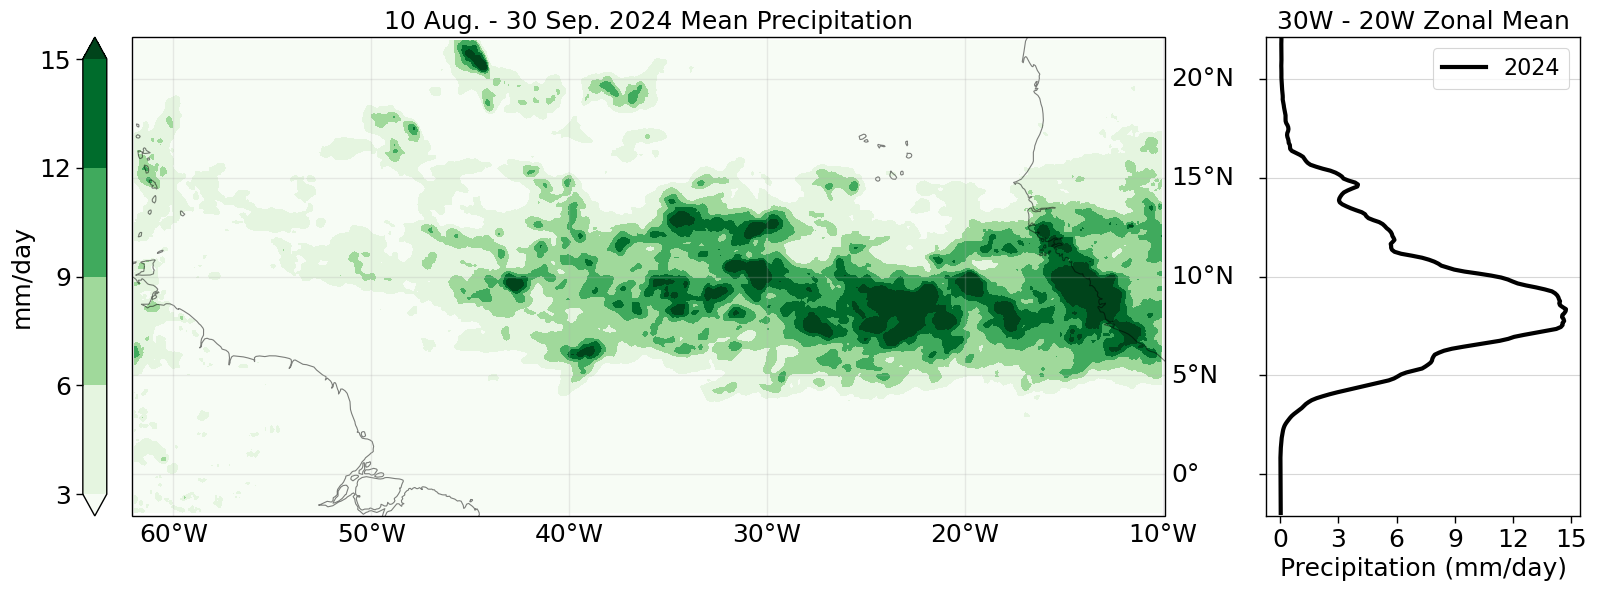

In [ ]:
# plot gsmap precip
fig = plt.figure(figsize = (17, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

ax1 = fig.add_subplot(gs[0],projection=ccrs.PlateCarree())
ax1.coastlines(resolution = '50m',alpha=0.5)
#ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

####################
## Plot 2024 precip as filled contours
####################
plt.contourf(gsmap2024mean.lon.values,
            gsmap2024mean.lat.values,
            gsmap2024mean.hourlyPrecipRate.values*24,
            cmap = 'Greens', levels = np.linspace(3,15,5),extend = 'both')

cbar=plt.colorbar(location='left',orientation='vertical', pad=0.02)
cbar.set_label('mm/day',fontsize=18)  #add a label to the colorbar
cbar.set_ticks(np.linspace(3,15,5))
cbar.set_ticklabels([f'{x:.0f}' for x in np.linspace(3,15,5)],fontsize=18)


#################
# Set the plot limits and title
#################
ax1.set_title(start_day+' '+start_mon+' - '+end_day+' '+end_mon+' 2024 Mean Precipitation',size=18)
ax1.set_xlim(lonMin, lonMax)
ax1.set_ylim(latMin, latMax)

################
# Plot zonal mean precip
################
ax2 = fig.add_subplot(gs[1])

lon1 = -30
lon2 = -20

zonalmean_precip_2024 = gsmap2024mean.hourlyPrecipRate.sel(lon=slice(lon1,lon2)).mean(dim='lon')

ax2.plot(zonalmean_precip_2024.values*24,zonalmean_precip_2024.lat,label='2024',color='k',linewidth=3)

ax2.set_xticks([0,3,6,9,12,15])
plt.setp(ax2.get_xticklabels(), fontsize=18)
#plt.setp(ax2.get_yticklabels(), fontsize=18)
ax2.set_yticks([0,5,10,15,20])
ax2.set_yticklabels([])
ax2.grid(True,which='major',axis='y',alpha=0.5)
ax2.legend(fontsize=16)
ax2.set_ylim([latMin,latMax])
#ax2.set_ylabel('Latitude',size=18)
ax2.set_xlabel('Precipitation (mm/day)',size=18)
ax2.set_title(str(-1*lon1) + "W - " + str(-1*lon2) + "W Zonal Mean",size=18)

sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

# Save figure
#plt.savefig('../../figures/Fig_precip_zonalmean_2024_wclimo_GSMaP.png')

ERA-5

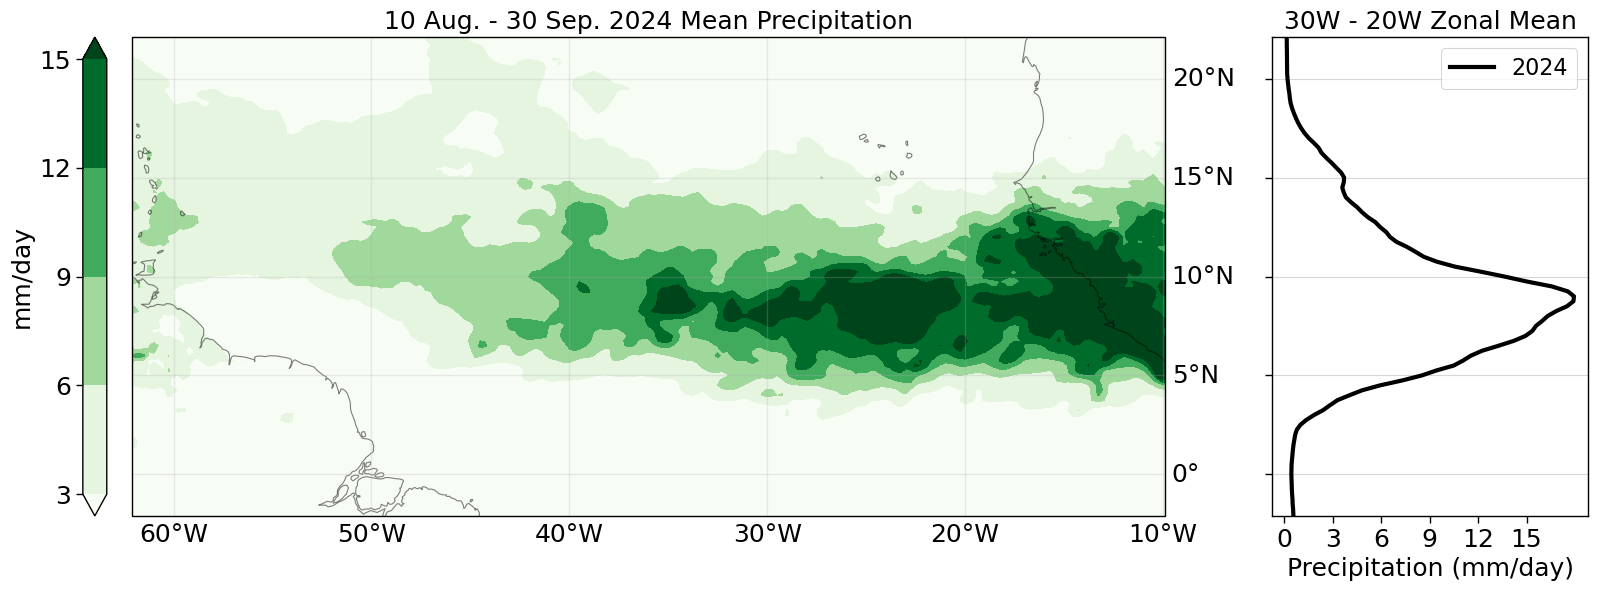

In [23]:
# plot era5 precip
fig = plt.figure(figsize = (17, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

ax1 = fig.add_subplot(gs[0],projection=ccrs.PlateCarree())
ax1.coastlines(resolution = '50m',alpha=0.5)
#ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

####################
## Plot 2024 precip as filled contours
####################
plt.contourf(era5precip2024mean.longitude.values,
            era5precip2024mean.latitude.values,
            era5precip2024mean,
            cmap = 'Greens', levels = np.linspace(3,15,5),extend = 'both')

cbar=plt.colorbar(location='left',orientation='vertical', pad=0.02)
cbar.set_label('mm/day',fontsize=18)  #add a label to the colorbar
cbar.set_ticks(np.linspace(3,15,5))
cbar.set_ticklabels([f'{x:.0f}' for x in np.linspace(3,15,5)],fontsize=18)


#################
# Set the plot limits and title
#################
ax1.set_title(start_day+' '+start_mon+' - '+end_day+' '+end_mon+' 2024 Mean Precipitation',size=18)
ax1.set_xlim(lonMin, lonMax)
ax1.set_ylim(latMin, latMax)

################
# Plot zonal mean precip
################
ax2 = fig.add_subplot(gs[1])

lon1 = -30
lon2 = -20

zonalmean_precip_2024 = era5precip2024mean.sel(longitude=slice(lon1,lon2)).mean(dim='longitude')

ax2.plot(zonalmean_precip_2024,zonalmean_precip_2024.latitude,label='2024',color='k',linewidth=3)

ax2.set_xticks([0,3,6,9,12,15])
plt.setp(ax2.get_xticklabels(), fontsize=18)
#plt.setp(ax2.get_yticklabels(), fontsize=18)
ax2.set_yticks([0,5,10,15,20])
ax2.set_yticklabels([])
ax2.grid(True,which='major',axis='y',alpha=0.5)
ax2.legend(fontsize=16)
ax2.set_ylim([latMin,latMax])
#ax2.set_ylabel('Latitude',size=18)
ax2.set_xlabel('Precipitation (mm/day)',size=18)
ax2.set_title(str(-1*lon1) + "W - " + str(-1*lon2) + "W Zonal Mean",size=18)

sns.set_context('paper') 
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

# Save figure
#plt.savefig('../../figures/Fig_precip_zonalmean_2024_wclimo_ERA5.png')

# Other precip plots

Individual contours of precip - GPCP

/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_90765/94096832.py:50: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  contour_paths2024 = contour2024.collections[0].get_paths()
/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_90765/94096832.py:51: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  contour_pathsClimo = contourClimo.collections[0].get_paths()


Contour 0 positions:
 [[-61.53254786  -2.        ]
 [-61.71432603  -1.80223756]
 [-55.85910079  -2.        ]
 [-56.          -1.93405927]
 [-56.09238776  -2.        ]
 [-62.          -0.55581796]
 [-61.31677773   0.        ]
 [-61.04060811   1.        ]
 [-61.           1.04261994]
 [-60.78798968   1.        ]
 [-60.           0.80360334]
 [-59.           0.66880024]
 [-58.64984741   1.        ]
 [-59.           1.29990312]
 [-60.           1.13429457]
 [-60.51611462   2.        ]
 [-61.           2.67094872]
 [-61.1964307    3.        ]
 [-61.           3.76561954]
 [-60.           3.97749874]
 [-59.96540645   4.        ]
 [-59.           4.07555433]
 [-58.           4.20181639]
 [-57.           4.66666386]
 [-56.20201674   5.        ]
 [-57.           5.29839142]
 [-58.           5.54689158]
 [-58.15052486   6.        ]
 [-58.91566594   7.        ]
 [-59.           7.16712852]
 [-59.27152161   8.        ]
 [-59.34111549   9.        ]
 [-59.28424391  10.        ]
 [-59.68843555  10.62

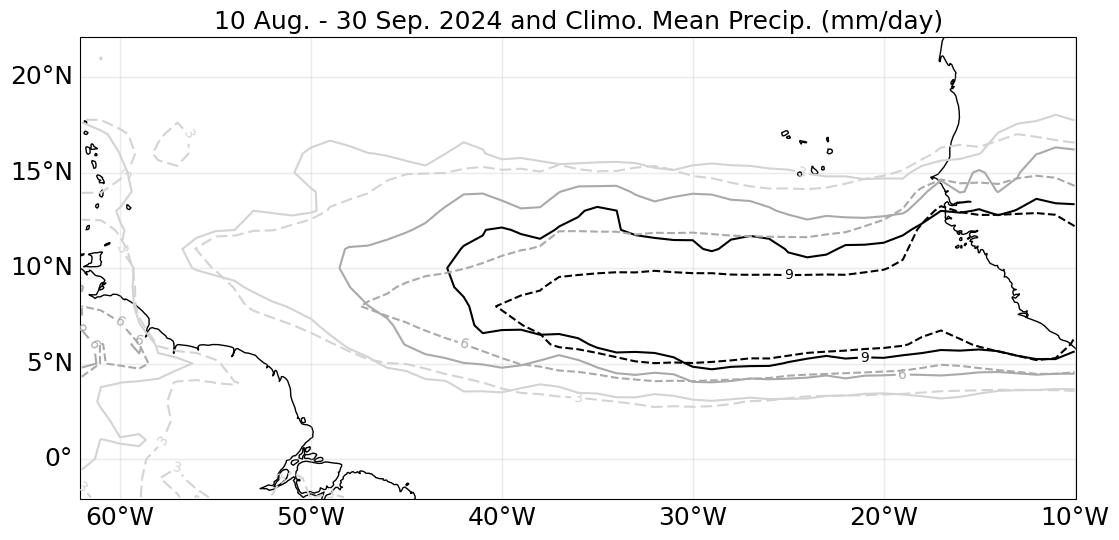

In [90]:
#Extract positions of specific contours of precip

plt.figure(figsize = (18, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines(resolution = '50m',alpha=1)
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

# Target contour value
target_precip = 9

# Create a contour plot
contour2024 = ax.contour(gpcp2024mean.longitude-360, gpcp2024mean.latitude, gpcp2024mean.precip.values, levels=[target_precip],colors='k')
contourClimo = ax.contour(gpcpClimoMean.longitude-360, gpcpClimoMean.latitude, gpcpClimoMean.precip.values, levels=[target_precip],colors='k',linestyles='dashed')
ax.clabel(contour2024, inline=True, fontsize=10)
ax.clabel(contourClimo, inline=True, fontsize=10)

# Target contour value
target_precip = 6

# Create a contour plot
contour2024 = ax.contour(gpcp2024mean.longitude-360, gpcp2024mean.latitude, gpcp2024mean.precip.values, levels=[target_precip],colors='darkgray')
contourClimo = ax.contour(gpcpClimoMean.longitude-360, gpcpClimoMean.latitude, gpcpClimoMean.precip.values, levels=[target_precip],colors='darkgray',linestyles='dashed')
ax.clabel(contour2024, inline=True, fontsize=10)
ax.clabel(contourClimo, inline=True, fontsize=10)

# Target contour value
target_precip = 3

# Create a contour plot
contour2024 = ax.contour(gpcp2024mean.longitude-360, gpcp2024mean.latitude, gpcp2024mean.precip.values, levels=[target_precip],colors='lightgray')
contourClimo = ax.contour(gpcpClimoMean.longitude-360, gpcpClimoMean.latitude, gpcpClimoMean.precip.values, levels=[target_precip],colors='lightgray',linestyles='dashed')
ax.clabel(contour2024, inline=True, fontsize=10)
ax.clabel(contourClimo, inline=True, fontsize=10)

plt.title("10 Aug. - 30 Sep. 2024 and Climo. Mean Precip. (mm/day)",size=18)
ax.set_xlim(lonMin, lonMax)
ax.set_ylim(latMin, latMax)

# Extract the contour paths
contour_paths2024 = contour2024.collections[0].get_paths()
contour_pathsClimo = contourClimo.collections[0].get_paths()

# Extract the positions of the specific contour
positions2024 = []
for path in contour_paths2024:
    positions2024.append(path.vertices)

positionsClimo = []
for path in contour_pathsClimo:
    positionsClimo.append(path.vertices)

# Print the positions
for i, pos in enumerate(positions2024):
    print(f"Contour {i} positions:\n", pos)

Latitudinal extent

In [81]:
positionsClimo_lons = [positionsClimo[0][:,0]]
positionsClimo_lats = [positionsClimo[0][:,1]]
positions2024_lons = [positions2024[0][:,0]]
positions2024_lats = [positions2024[0][:,1]]

# find indices for lons between -35 and -25
ipositions2024 = np.where((positions2024_lons[0] > -35) & (positions2024_lons[0] < -25))
ipositionsClimo = np.where((positionsClimo_lons[0] > -35) & (positionsClimo_lons[0] < -25))

#get latitudes for these lons
latpositions2024 = positions2024_lats[0][ipositions2024]
latpositionsClimo = positionsClimo_lats[0][ipositionsClimo]

#split the lats into two groups
latpositions2024_north = latpositions2024[latpositions2024 > 8]
latpositions2024_south = latpositions2024[latpositions2024 < 8]
latpositionsClimo_north = latpositionsClimo[latpositionsClimo > 8]
latpositionsClimo_south = latpositionsClimo[latpositionsClimo < 8]

#find the mean difference in latitudes
lat_extent2024 = np.mean(latpositions2024_north)-np.mean(latpositions2024_south)
lat_extentClimo = np.mean(latpositionsClimo_north)-np.mean(latpositionsClimo_south)

print("latitudinal extent of 3 mm/day precip between 25W and 35W in 2024 is",lat_extent2024,"and in climo is",lat_extentClimo)


latitudinal extent of 3 mm/day precip between 25W and 35W in 2024 is 12.163803936880266 and in climo is 11.935985000616242


## CWV plots

Individual contour of CWV

/opt/anaconda3/envs/awing/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


(-2.1, 22.1)

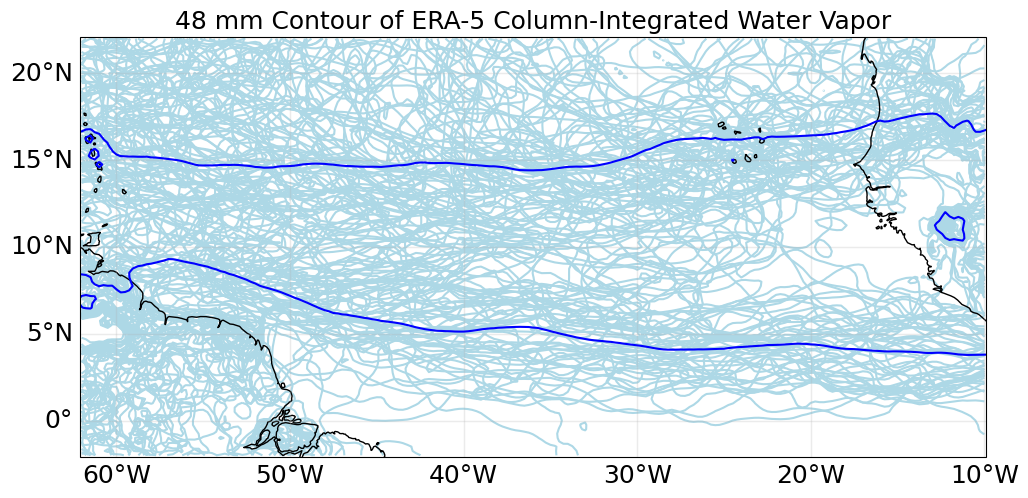

In [94]:
#Plot 48 mm contour of CWV each day

#plt.figure(figsize = (18, 6))
plt.figure(figsize = (29.7/2.54, 42.0/2.54))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines(resolution = '50m',alpha=1,zorder=2)
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
#gl.bottom_labels = False
#gl.left_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl.ylocator = mticker.FixedLocator([-10, -5, 0, 5, 10, 15, 20, 25, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

tcwv_box = era5.tcwv.sel(latitude=slice(latMax,latMin), longitude=slice(lonMin,lonMax))
latbox = era5.latitude.sel(latitude=slice(latMax,latMin))
lonbox = era5.longitude.sel(longitude=slice(lonMin,lonMax))

#################
## Plot 48 mm contour each day
#################

tcwv_plot_times = pd.date_range(start_time,end_time,freq='D')

for i in range(0,len(tcwv_plot_times)):
    #plot 48 mm contour
    plt.contour(lonbox,latbox,tcwv_box.sel(valid_time=tcwv_plot_times[i],method='nearest'),levels = [48],colors = 'lightblue',zorder=1)


#################
## Plot 48 mm contour
#################
plt.contour(era5.longitude.values,era5.latitude.values, tcwv_mean,levels = [48],colors = 'b',linewidth = 2)

#################
# Set the plot limits and title
#################
plt.title(f"48 mm Contour of ERA-5 Column-Integrated Water Vapor",size=18)
ax.set_xlim(lonMin, lonMax)
ax.set_ylim(latMin, latMax)

#plt.savefig('../figures/Fig_CWV_48mm_contour.pdf',bbox_inches='tight')


Contour density of CWV

/var/folders/ym/zbw7d2hd013cdrqzhhl0z7580000gn/T/ipykernel_90765/3196456686.py:22: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  contour_pathsCWV = contourCWV.collections[0].get_paths()


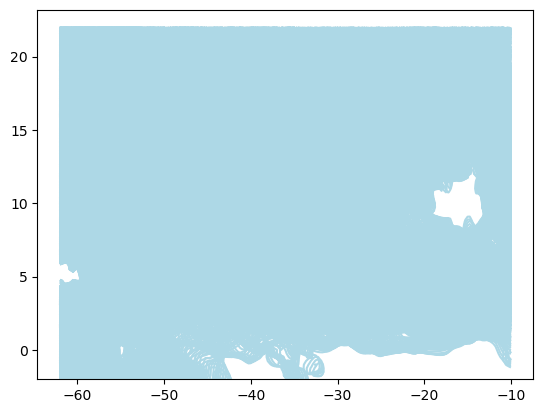

In [95]:
# Calculate density of 48 mm contours of CWV

# Contour density calculation
# grid
gridsize = 1 # Grid size in degrees
Xp = np.arange(lonMin, lonMax+1, gridsize)  # Longitude grid
Yp = np.arange(latMin, latMax+1, gridsize)      # Latitude grid 
lx = len(Xp)
ly = len(Yp)

# Initialize contour density array
contour_den = np.zeros((ly, lx))

tcwv_plot_times = pd.date_range(start_time,end_time,freq='h')
# Create a contour plot
fig, ax = plt.subplots()
for i in range(0,len(tcwv_plot_times)):
    #plot 48 mm contour
    contourCWV = plt.contour(lonbox,latbox,tcwv_box.sel(valid_time=tcwv_plot_times[i],method='nearest'),levels = [48],colors = 'lightblue')

    # Extract the contour paths
    contour_pathsCWV = contourCWV.collections[0].get_paths()

    # Extract the positions of the specific contour
    positionsCWV = []
    for path in contour_pathsCWV:
        positionsCWV.append(path.vertices)

    positionsCWV = np.squeeze(positionsCWV)

    # Assign the contour to the grid box
    for k in range(len(positionsCWV)):
        # If the contour can be assigned to 2 grid boxes, choose the nearest one
        ix = np.where((Xp >= positionsCWV[k,0] - gridsize / 2) &
                        (Xp < positionsCWV[k,0] + gridsize / 2))[0]
        
        if len(ix) > 1:
            diff = Xp[ix] - positionsCWV[k,0]
            ixv = ix[np.argmin(np.abs(diff))]
        else:
            ixv = ix[0] if ix.size > 0 else None

        iy = np.where((Yp >= positionsCWV[k,1] - gridsize / 2) &
                        (Yp < positionsCWV[k,1] + gridsize / 2))[0]
        
        if len(iy) > 1:
            diff = Yp[iy] - positionsCWV[k,1]
            iyv = iy[np.argmin(np.abs(diff))]
        else:
            iyv = iy[0] if iy.size > 0 else None

        # Update the track density if ixv and iyv are valid
        if ixv is not None and iyv is not None:
            contour_den[iyv, ixv] += 1/24 #because we are summing over 24 hours



/opt/anaconda3/envs/awing/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


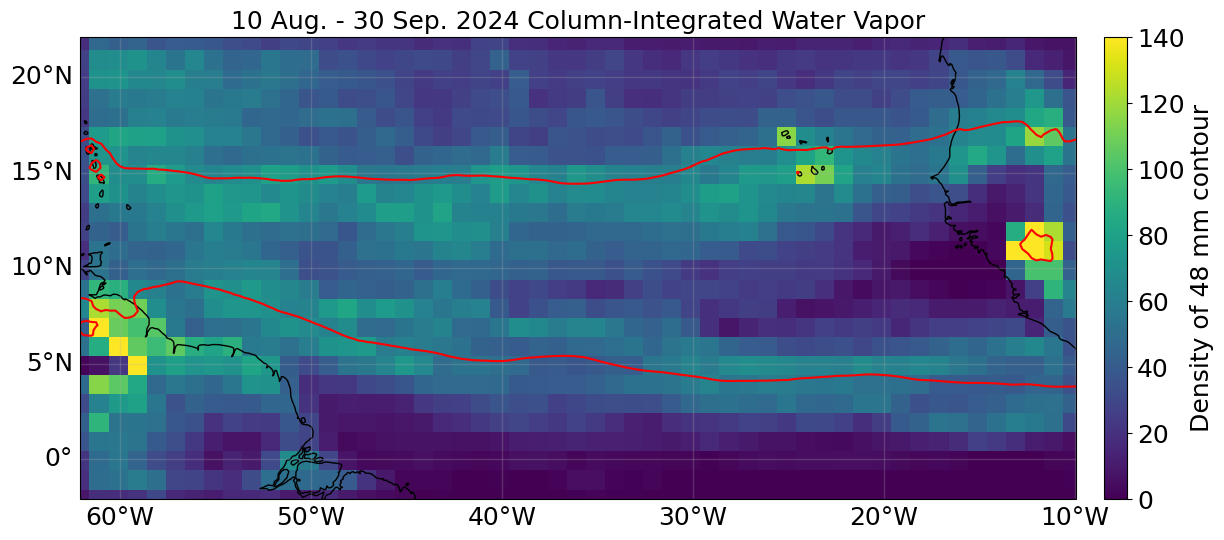

In [96]:
plt.figure(figsize = (18, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution = '50m',linewidth=1,alpha=1)
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

# Plot the contour density (hourly contours)
plt.pcolormesh(Xp,Yp,contour_den,vmin=0,vmax=140)
# Add colorbar
cbar=plt.colorbar(orientation='vertical', pad=0.02)
cbar.set_label('Density of 48 mm contour',fontsize=18)  #add a label to the colorbar

#plot mean 48 mm contour
plt.contour(era5.longitude.values,era5.latitude.values, tcwv_mean,levels = [48],colors = 'r',linewidth = 2)

#Set the plot limits and title
cbar.ax.tick_params(labelsize=18)
ax.set_xlim(lonMin, lonMax)
ax.set_ylim(latMin, latMax)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('10 Aug. - 30 Sep. 2024 Column-Integrated Water Vapor', fontsize=18)  

plt.savefig('../figures/Fig_CWV_48mm_contour_density.png')